In [0]:

import re
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle

In [0]:
#libraries
import os 
import kagglehub
from pyspark.sql.functions import desc

#dataset path here:
path = kagglehub.dataset_download("kazanova/sentiment140")
print("Path To The Dataset",path)


from os import listdir
from os.path import isfile, join
file_path = "/root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2/"  # Update the path if necessary
onlyfiles = [path+"/"+f for f in listdir(path) if isfile(join(path,f))]
print(onlyfiles)

tweetDf =spark.read.csv('file:/root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2/training.1600000.processed.noemoticon.csv')
tweetDf = (
    tweetDf.withColumnRenamed("_c0", "ID")
           .withColumnRenamed("_c1", "TweetID")
           .withColumnRenamed("_c2", "Date")
           .withColumnRenamed("_c3", "Query")
           .withColumnRenamed("_c4", "Users")
           .withColumnRenamed("_c5", "Text")
          #added 1 new sentiment coloumn with 0=neg 4=positive
)

# Show the DataFrame
tweetDf.show()


#ordering by descending
tweetDf.groupBy("USERS").count().orderBy(desc("count")).limit(1).show()


spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

from pyspark.sql.functions import to_timestamp

# Convert the string column to a timestamp
tweetDf = tweetDf.withColumn("Date", to_timestamp(tweetDf["Date"], "EEE MMM dd HH:mm:ss Z yyyy"))

tweetDf.show()



#find the start and end date of the tweets 
from pyspark.sql.functions import min, max

# Find the start and end dates
date_range = tweetDf.agg(min("Date").alias("Start_Date"), max("Date").alias("End_Date"))
date_range.show()




Path To The Dataset /root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2
['/root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2/training.1600000.processed.noemoticon.csv']
+---+----------+--------------------+--------+---------------+--------------------+
| ID|   TweetID|                Date|   Query|          Users|                Text|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|  

In [0]:
# DATASET PREPROCESSING, SPLITTING 

trainData, testData = tweetDf.randomSplit([0.8, 0.2], seed=42)

trainData.show()
testData.show()

+---+----------+-------------------+--------+---------------+--------------------+
| ID|   TweetID|               Date|   Query|          Users|                Text|
+---+----------+-------------------+--------+---------------+--------------------+
|  0|1467810369|2009-04-07 05:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|2009-04-07 05:19:49|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467811184|2009-04-07 05:19:57|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|2009-04-07 05:19:57|NO_QUERY|         Karoli|@nationwideclass ...|
|  0|1467811372|2009-04-07 05:20:00|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  0|1467811594|2009-04-07 05:20:03|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  0|1467812025|2009-04-07 05:20:09|NO_QUERY|        mimismo|@twittera que me ...|
|  0|1467812416|2009-04-07 05:20:16|NO_QUERY| erinx3leannexo|spring break in p...|
|  0|1467812579|2009-04-07 05:20:17|NO_QUERY|   pardonlauren|I just re-pierced...|
|  0

In [0]:
tweetDf.show()

+---+----------+-------------------+--------+---------------+--------------------+
| ID|   TweetID|               Date|   Query|          Users|                Text|
+---+----------+-------------------+--------+---------------+--------------------+
|  0|1467810369|2009-04-07 05:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|2009-04-07 05:19:49|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|2009-04-07 05:19:53|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|2009-04-07 05:19:57|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|2009-04-07 05:19:57|NO_QUERY|         Karoli|@nationwideclass ...|
|  0|1467811372|2009-04-07 05:20:00|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  0|1467811592|2009-04-07 05:20:03|NO_QUERY|        mybirch|         Need a hug |
|  0|1467811594|2009-04-07 05:20:03|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  0|1467811795|2009-04-07 05:20:05|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|  0

In [0]:
#this is the code for bert classifier of tweetDF dataset
from pyspark.sql.functions import when

# Adding a new column 'Sentiment' with values 'negative' for 0 and 'positive' for 4
tweetDf = tweetDf.withColumn("Sentiment", 
                             when(tweetDf["Query"] == 0, "negative")
                             .when(tweetDf["Query"] == 4, "positive")
                             .otherwise("neutral"))

# Show the DataFrame with the new Sentiment column
tweetDf.show()


+---+----------+-------------------+--------+---------------+--------------------+---------+
| ID|   TweetID|               Date|   Query|          Users|                Text|Sentiment|
+---+----------+-------------------+--------+---------------+--------------------+---------+
|  0|1467810369|2009-04-07 05:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|  neutral|
|  0|1467810672|2009-04-07 05:19:49|NO_QUERY|  scotthamilton|is upset that he ...|  neutral|
|  0|1467810917|2009-04-07 05:19:53|NO_QUERY|       mattycus|@Kenichan I dived...|  neutral|
|  0|1467811184|2009-04-07 05:19:57|NO_QUERY|        ElleCTF|my whole body fee...|  neutral|
|  0|1467811193|2009-04-07 05:19:57|NO_QUERY|         Karoli|@nationwideclass ...|  neutral|
|  0|1467811372|2009-04-07 05:20:00|NO_QUERY|       joy_wolf|@Kwesidei not the...|  neutral|
|  0|1467811592|2009-04-07 05:20:03|NO_QUERY|        mybirch|         Need a hug |  neutral|
|  0|1467811594|2009-04-07 05:20:03|NO_QUERY|           coZZ|@LOLTrish

In [0]:
# this is an example of bert classifier for text classification of one line

from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

# Assembling the document from the input text
documentAssembler = DocumentAssembler() \
    .setInputCol("Text") \
    .setOutputCol("document")

# Tokenizing the text
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Loading a pre-trained sequence classification model
# You can replace `BertForSequenceClassification.pretrained()` with your selected model 
# For example: BertForSequenceClassification.pretrained("distilbert_sequence_classifier_sst2", "en")
sequenceClassifier = BertForSequenceClassification.pretrained() \
    .setInputCols(["token", "document"]) \
    .setOutputCol("label") \
    .setCaseSensitive(True)

# Defining the pipeline with document assembler, tokenizer, and classifier
pipeline = Pipeline().setStages([
    documentAssembler,
    tokenizer,
    sequenceClassifier
])


# Fitting the pipeline and transforming the data
result = pipeline.fit(tweetDf).transform(tweetDf)   #modify text classification code to add the tweetDf to process the result

result.select("label.result").show(truncate=False)
#--------------------------------------







bert_base_sequence_classifier_imdb download started this may take some time.
Approximate size to download 387.6 MB
[OK!]
+------+
|result|
+------+
|[neg] |
|[neg] |
|[neg] |
|[neg] |
|[pos] |
|[neg] |
|[neg] |
|[pos] |
|[neg] |
|[pos] |
|[neg] |
|[neg] |
|[neg] |
|[neg] |
|[neg] |
|[pos] |
|[neg] |
|[neg] |
|[pos] |
|[neg] |
+------+
only showing top 20 rows



In [0]:
# Check if the file exists
import os

file_path = "/root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2/training.1600000.processed.noemoticon.csv"

if os.path.exists(file_path):
    print("File exists:", file_path)
else:
    print("File not found:", file_path)


import pandas as pd

# Show the updated DataFrame
DATASET_COLUMNS = ['target', 'id', 'date', 'flag', 'user', 'text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv(file_path, encoding = DATASET_ENCODING, names = DATASET_COLUMNS)
df.sample(5)

File exists: /root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2/training.1600000.processed.noemoticon.csv


,target,id,date,flag,user,text
1453204,4,2063209600,Sun Jun 07 01:46:15 PDT 2009,NO_QUERY,jamesplata,is tired but HAPPY. http://plurk.com/p/z1a6a
839893,4,1559549434,Sun Apr 19 11:26:00 PDT 2009,NO_QUERY,beartwinsmom,@jasonmitchener You're most welcome!
443170,0,2067482767,Sun Jun 07 12:25:25 PDT 2009,NO_QUERY,soledaddl,"@jisellex197 Yeah, I do. I posted them on th..."
1551772,4,2184207052,Mon Jun 15 15:34:29 PDT 2009,NO_QUERY,leviself,@atoponce I really wouldn't worry about a #col...
1250471,4,1996298206,Mon Jun 01 14:51:10 PDT 2009,NO_QUERY,BOSSBADDBEAUTY,BOUTTA LEAVE DA BX ON MII WAY 2 HARLEM WORLD.....


In [0]:
df.columns

Out[9]: Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')

In [0]:
print('Length of the data is: ', len(df))
df.shape
df.info()
df.dtypes

np.sum(df.isnull().any(axis = 1))

Length of the data is:  1600000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
Out[10]: 0

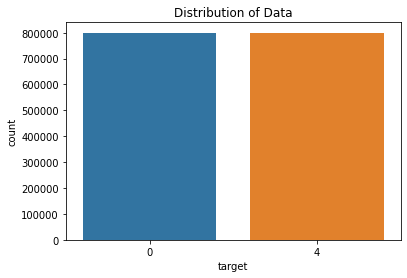

In [0]:

# Plotting the distribution of dataset

ax = df.groupby('target').count().plot(kind = 'bar', title = 'Distribution of Data', legend = False)
ax.set_xticklabels(['Negative', 'Positive'], rotation = 0)

# Storing data in Lists

text, sentiment = list(df['text']), list(df['target'])

# Saving the figure

plt.savefig('Distribution_of_Data', bbox_inches = 'tight')




sns.countplot(x = 'target', data = df)

# Save the figure
plt.savefig('target', bbox_inches = 'tight')

In [0]:
# Selecting the text and Target Column for our further analysis 
data = df[['text', 'target']]

# Replacing the values for easy understanding [Assigning 1 to positive sentiment 4]
data['target'] = data['target'].replace(4, 1)

# Print unique values of target variables
data['target'].unique()

# Separating Positive and Negative tweets
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]


# Taking 1/4th data for easy processing
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

# Combining Positive and Negative tweets
dataset = pd.concat([data_pos, data_neg])

# Making all the text[tweets] in lowercase
dataset['text'] = dataset['text'].str.lower()
dataset['text'].tail()

<command-168538362967382>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4, 1)


Out[12]: 19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [0]:
#stopwords removal
stopwordList = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']


# Cleaning and removing the above stopwords list from the tweets
STOPWORDS = set(stopwordList)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()      



# Cleaning and removing punctuations
import string
english_punctuations = string.punctuation
punctuation_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuation_list)
    return text.translate(translator)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

Out[13]: 19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [0]:

nltk.download('stopwords')
print(stopwords.words('english'))


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# checking the distribution of target column
dataset['target'].value_counts()

dataset.replace({'target':{4:1}}, inplace =True)    # 0 --> Negative Tweet ,  1 --> Positive Tweeet

port_steam = PorterStemmer()


def stemming(content):
    stemmer = nltk.SnowballStemmer('english')
    stemmed_content = content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

dataset['stemmed_content'] = dataset['text'].apply(stemming) #50 min to wait for this execution
dataset.head()



,text,target,stemmed_content
800000,love health4uandpets u guys r best,1,love health4uandpet u guy r best
800001,im meeting one besties tonight cant wait girl...,1,im meet one besti tonight cant wait girl talk
800002,darealsunisakim thanks twitter add sunisa got ...,1,darealsunisakim thank twitter add sunisa got m...
800003,sick really cheap hurts much eat real food plu...,1,sick realli cheap hurt much eat real food plus...
800004,lovesbrooklyn2 effect everyone,1,lovesbrooklyn2 effect everyon


In [0]:
print(dataset['stemmed_content'])

print(dataset['target'])



# separating the data and label
X = dataset['stemmed_content'].values
Y = dataset['target'].values



800000                     love health4uandpet u guy r best
800001        im meet one besti tonight cant wait girl talk
800002    darealsunisakim thank twitter add sunisa got m...
800003    sick realli cheap hurt much eat real food plus...
800004                        lovesbrooklyn2 effect everyon
                                ...                        
19995     much time weekend work trip malmï¿½ frisat tod...
19996                                       one day holiday
19997                          feel right hate damn humprey
19998     geezi hv read whole book person type embark ty...
19999        threw sign donni bent get thinge made sad face
Name: stemmed_content, Length: 40000, dtype: object
800000    1
800001    1
800002    1
800003    1
800004    1
         ..
19995     0
19996     0
19997     0
19998     0
19999     0
Name: target, Length: 40000, dtype: int64


In [0]:
print(X)

print(Y)

['love health4uandpet u guy r best'
 'im meet one besti tonight cant wait girl talk'
 'darealsunisakim thank twitter add sunisa got meet hin show dc area sweetheart'
 ... 'feel right hate damn humprey'
 'geezi hv read whole book person type embark type fun sunday warrrrhhh'
 'threw sign donni bent get thinge made sad face']
[1 1 1 ... 0 0 0]


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

print(X.shape, X_train.shape, X_test.shape)

print(X_train)


print(Y_test)


print(type(X_train))



# converting the textual data to numerical data
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
     

print(X_train)

(40000,) (32000,) (8000,)
['beautifullady09 good luck hear twitter addict bewar'
 'youreba mcentir amp kelli clarkson' 'realiz im talk one' ...
 'zachsang tell im sorri make sad'
 'ok ok lotsa plead omshreshti leav comp watch wall e'
 'httptwitpiccom2yetf ampamp httptwitpiccom2yetx workspac de hoje']
[1 0 1 ... 1 1 1]
<class 'numpy.ndarray'>
  (0, 4063)	0.5042920371242556
  (0, 1334)	0.38641234645318623
  (0, 35528)	0.23689773222275357
  (0, 14092)	0.3056612006952772
  (0, 20931)	0.3206666585082483
  (0, 13102)	0.1992939647950793
  (0, 3749)	0.551616301768051
  (1, 6793)	0.47688725724376074
  (1, 18859)	0.41432521908306896
  (1, 2106)	0.23811141350829393
  (1, 21886)	0.5216397758354765
  (1, 38548)	0.5216397758354765
  (2, 25198)	0.41095035174002054
  (2, 33361)	0.5381675737027135
  (2, 16616)	0.31233210141864515
  (2, 28418)	0.6662913247544959
  (3, 11706)	0.429706489731198
  (3, 10851)	0.32255388259852735
  (3, 26435)	0.5373841287387539
  (3, 27094)	0.2918964202533286
  (3, 34884)	0.

In [0]:
#----------------------------------------------- USING LOGISTIC REGRESSION
model = LogisticRegression(max_iter=1000)

model.fit(X_train, Y_train)

Out[19]: LogisticRegression(max_iter=1000)

In [0]:

# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)


print('Accuracy score on the training data :', training_data_accuracy)
     
# accuracy score on the testing data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)
          


print('Accuracy score on the testing data :', test_data_accuracy)          


#SO WE HAVE Model accuracy = 78.2%

Accuracy score on the training data : 0.844375
Accuracy score on the testing data : 0.75475


In [0]:
X_new = X_test[200]
print(Y_test[200])

prediction = model.predict(X_new)
print(prediction)

if (prediction[0] == 0):
  print('Negative Tweet')

else:
  print('Positive Tweet')

0
[0]
Negative Tweet


In [0]:

X_new = X_test[4]
print(Y_test[3])

prediction = model.predict(X_new)
print(prediction)

if (prediction[0] == 0):
  print('Negative Tweet')

else:
  print('Positive Tweet')
     


     #---------------------------------------------------------------------------------------------------------------------#
     #this means we can classify the tweets accordingly now and its pretty useful for directly checking the tweet sentiments

0
[1]
Positive Tweet


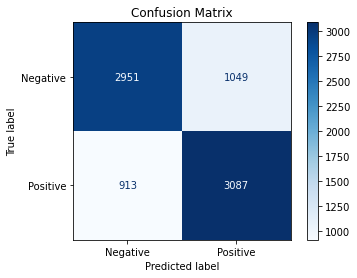

In [0]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate predictions
y_pred = model.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [0]:
from sklearn.metrics import classification_report

# Generate predictions
y_pred = model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(Y_test, y_pred, target_names=['Negative', 'Positive']))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.74      0.75      4000
    Positive       0.75      0.77      0.76      4000

    accuracy                           0.75      8000
   macro avg       0.76      0.75      0.75      8000
weighted avg       0.76      0.75      0.75      8000



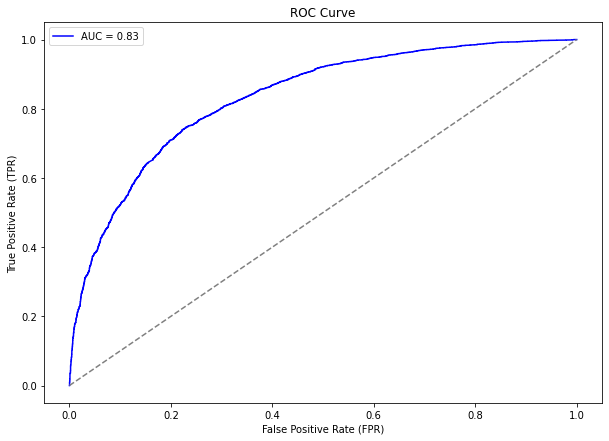

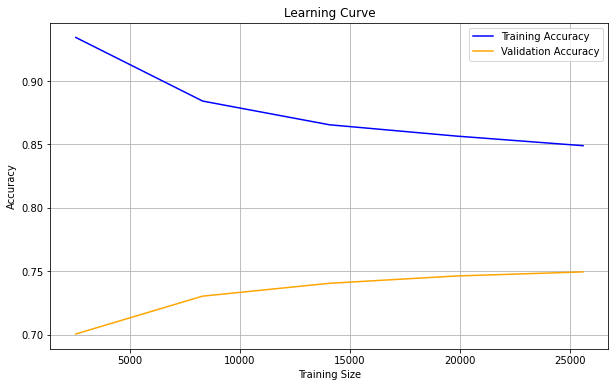

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate probabilities
y_probs = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_probs)

# Plot ROC Curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc_score(Y_test, y_probs):.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


#...........................................
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(model, X_train, Y_train, cv=5, scoring='accuracy')

# Calculate mean and std
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, test_mean, label='Validation Accuracy', color='orange')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()



In [0]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],    # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs']
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate best model on test data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, Y_test)
print("Test Accuracy after Hyperparameter Tuning:", test_accuracy)

Best Parameters: {'C': 1, 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.7495624999999999
Test Accuracy after Hyperparameter Tuning: 0.75475


In [0]:
dataset.columns

Out[27]: Index(['text', 'target', 'stemmed_content'], dtype='object')

In [0]:
file_path

Out[28]: '/root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2/training.1600000.processed.noemoticon.csv'

In [0]:
tweetDf = tweetDf.withColumnRenamed("userAlias", "Users")

# Now proceed with community detection, using 'userAlias'
edges = tweetDf.select("TweetID", "Users")

tweetDf.columns


Out[29]: ['ID', 'TweetID', 'Date', 'Query', 'Users', 'Text', 'Sentiment']

In [0]:
import networkx as nx
import pandas as pd
import community as community_louvain
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
pandas_df = tweetDf.toPandas()

# Subsampling the data to 5% for faster computation
sampled_df = pandas_df.sample(frac=0.05, random_state=42)

# Create a graph
G = nx.Graph()

# Adding nodes (users only)
users = sampled_df['Users'].unique()
G.add_nodes_from(users)

# Adding edges (only user-user or user-tweet connections, if necessary)
for _, row in sampled_df.iterrows():
    G.add_edge(row['Users'], row['TweetID'])

# Detect communities using Louvain
partition = community_louvain.best_partition(G)

# Display the detected communities
print("Number of communities detected:", len(set(partition.values())))
community_summary = pd.DataFrame.from_dict(partition, orient='index', columns=['Community'])
print(community_summary['Community'].value_counts())

# Plot (Optional: Only for small graphs)
if len(G) < 1000:  # Avoid plotting large graphs
    pos = nx.spring_layout(G, k=0.15, iterations=10)
    plt.figure(figsize=(10, 7))
    nx.draw_networkx_nodes(G, pos, node_size=40, cmap=plt.cm.jet, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title("Community Detection using Louvain")
    plt.show()
else:
    print("Graph too large to plot effectively.")



    #Yes, the community detection is complete! However, the output indicates an excessively fragmented graph with 67,941 communities, which is likely caused by:

#Sparse Connectivity: Many users might be connected to only a few edges (e.g., tweet IDs), causing isolated or near-isolated clusters.
#Disconnected Components: The graph may have many small connected components instead of forming meaningful communities.
#Here’s what you can do to refine and make sense of this result


Number of communities detected: 67941
3639     33
480      21
97       20
2127     19
2981     18
         ..
25471     2
37922     2
37923     2
37924     2
14908     2
Name: Community, Length: 67941, dtype: int64
Graph too large to plot effectively.


In [0]:
#- HASHTAGS DETECTION #-
from pyspark.sql.functions import regexp_extract, split, explode

# Extract hashtags using regex
tweetDf = tweetDf.withColumn('Hashtags', regexp_extract(tweetDf['Text'], r'(#\w+)', 0))

# Split hashtags into an array and explode into separate rows
tweetDf = tweetDf.withColumn('Hashtags', split(tweetDf['Text'], ' '))
hashtagDf = tweetDf.select('TweetID', explode(tweetDf['Hashtags']).alias('Hashtag'))


In [0]:
# Filter out empty hashtags and those that do not start with '#'
hashtagDf = hashtagDf.filter(hashtagDf.Hashtag != '')
hashtagDf = hashtagDf.filter(hashtagDf.Hashtag.startswith('#'))

In [0]:
# Count occurrences of each hashtag
hashtag_counts = hashtagDf.groupBy('Hashtag').count().orderBy(desc('count'))

# Show the top 10 hashtags
hashtag_counts.show(10)

+-------------+-----+
|      Hashtag|count|
+-------------+-----+
|#followfriday| 1827|
|          #fb| 1728|
| #squarespace|  818|
|     #seb-day|  498|
|          #FF|  497|
|            #|  472|
|#FollowFriday|  407|
|           #1|  391|
| #musicmonday|  382|
|#iranelection|  337|
+-------------+-----+
only showing top 10 rows



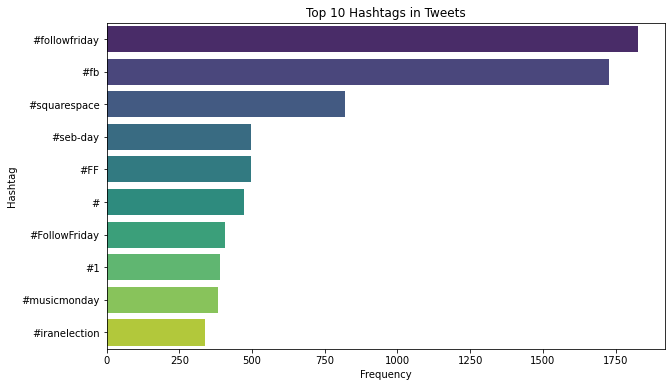

In [0]:
import matplotlib.pyplot as plt

# Collect the top hashtags for visualization
top_hashtags = hashtag_counts.limit(10).toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='Hashtag', data=top_hashtags, palette='viridis')
plt.title('Top 10 Hashtags in Tweets')
plt.xlabel('Frequency')
plt.ylabel('Hashtag')
plt.show()

In [0]:
# Join with the original DataFrame to get sentiment
sentiment_by_hashtag = hashtagDf.join(tweetDf.select('TweetID', 'Sentiment'), on='TweetID')

# Count sentiment occurrences by hashtag
sentiment_counts = sentiment_by_hashtag.groupBy('Hashtag', 'Sentiment').count().orderBy('Hashtag')

# Show the sentiment counts for hashtags
sentiment_counts.show()

+--------------------+---------+-----+
|             Hashtag|Sentiment|count|
+--------------------+---------+-----+
|                   #|  neutral|  472|
|                  #!|  neutral|    7|
|                 #!!|  neutral|    1|
|                #!!!|  neutral|    1|
|   #!#$!#$!!#@@#@!!!|  neutral|    1|
|            #!?@$?!!|  neutral|    1|
|       #!@$@#%#$%#$%|  neutral|    1|
|               #!@%#|  neutral|    1|
|               #####|  neutral|    2|
|              ######|  neutral|    1|
|#################...|  neutral|    1|
|#####ssssqqqquuuu...|  neutral|    1|
|           ###-MICA.|  neutral|    1|
|                ###1|  neutral|    1|
|                ##$@|  neutral|    1|
|                ##'s|  neutral|    1|
|           ##@*&amp;|  neutral|    1|
|   ##CrocsFeelGood01|  neutral|    1|
|      ##Followfriday|  neutral|    2|
|   ##awaresg_tshirts|  neutral|    1|
+--------------------+---------+-----+
only showing top 20 rows



+----------+--------------------+-----+
|      Date|             Hashtag|count|
+----------+--------------------+-----+
|2009-04-07|              #TTSC?|    1|
|2009-04-07|             #ottawa|    1|
|2009-04-07|                #msu|    1|
|2009-04-07|             #Mesh09|    1|
|2009-04-07|          #barcodes.|    1|
|2009-04-07|             #Berlin|    1|
|2009-04-07|       #twitteriffic|    1|
|2009-04-07|                 #f1|    1|
|2009-04-07|             #Heroes|    3|
|2009-04-07|                #CNN|    1|
|2009-04-07|                #WCH|    1|
|2009-04-07|             #search|    1|
|2009-04-07|          #weshareDI|    1|
|2009-04-07|  #AutomationAtaCost|    1|
|2009-04-07|                  #1|    7|
|2009-04-07|              #...We|    1|
|2009-04-07|                   #|    3|
|2009-04-07|             #Virgin|    1|
|2009-04-07|#&amp;$(#&amp;$!(...|    1|
|2009-04-07|               #gsoc|    1|
+----------+--------------------+-----+
only showing top 20 rows



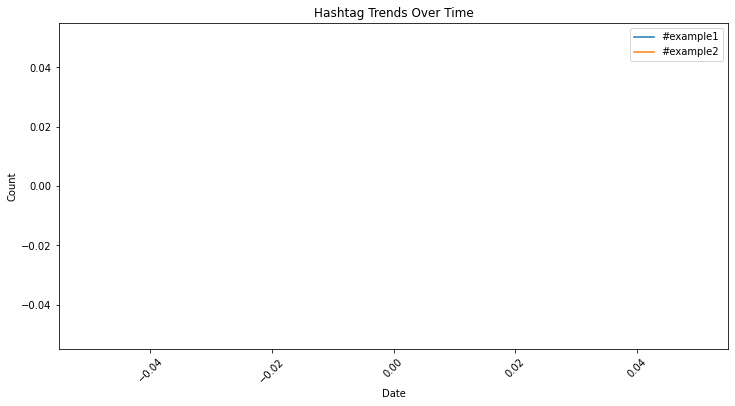

In [0]:
from pyspark.sql.functions import to_date

# Convert the Date column to date format
tweetDf = tweetDf.withColumn("Date", to_date(tweetDf["Date"]))

# Extract hashtags along with the date
hashtag_with_date = hashtagDf.join(tweetDf.select('TweetID', 'Date'), on='TweetID')

# Count hashtags by date
hashtag_trends = hashtag_with_date.groupBy('Date', 'Hashtag').count().orderBy('Date')

# Show the trends
hashtag_trends.show()

# Convert to Pandas for visualization
hashtag_trends_pd = hashtag_trends.toPandas()

# Filter for specific hashtags to visualize
specific_hashtags = ['#example1', '#example2']  # Replace with actual hashtags of interest
trends_filtered = hashtag_trends_pd[hashtag_trends_pd['Hashtag'].isin(specific_hashtags)]

# Plotting
plt.figure(figsize=(12, 6))
for hashtag in specific_hashtags:
    plt.plot(trends_filtered[trends_filtered['Hashtag'] == hashtag]['Date'],
             trends_filtered[trends_filtered['Hashtag'] == hashtag]['count'],
             label=hashtag)

plt.title('Hashtag Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.show()
